## Connect GG Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Yolo_v7

In [ ]:
# Clone YOLOv7
%cd /content/drive/Shareddrives/AI/yolov7_train
!git clone https://github.com/augmentedstartups/yolov7.git #https://github.com/WongKinYiu/yolov7

In [ ]:
# Download pretrain weight
%cd /content/drive/Shareddrives/AI/yolov7_train/yolov7
!mkdir pretrain
%cd pretrain
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

## Import Library

In [5]:
# Cài đặt các thư viện cần thiết để train YOLOv7
%cd /content/drive/Shareddrives/AI/yolov7_train/yolov7
!pip install -r requirements.txt

/content/drive/Shareddrives/AI/yolov7_train/yolov7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 28.2 MB/s 


## Clear model

In [ ]:
!rm -rf /content/drive/Shareddrives/AI/yolov7_train/yolov7/runs/train
!rm -rf /content/drive/Shareddrives/AI/yolov7_train/yolov7/runs/detect

## Train model

In [6]:
# Tổ chức lại thư mục train. Lý do: Vì YOLOv7 yêu cầu
# train
#   - images
#   - labels
# test
#   - images
#   - labels

%cd /content/drive/Shareddrives/AI/yolov7_train/
!rm -rf train_data
!mkdir train_data
!mkdir train_data/images
!mkdir train_data/labels
%cd /content/drive/Shareddrives/AI/Data/
!cp */*.jpg /content/drive/Shareddrives/AI/yolov7_train/train_data/images
!cp */*.txt /content/drive/Shareddrives/AI/yolov7_train/train_data/labels

/content/drive/Shareddrives/AI/yolov7_train
/content/drive/Shareddrives/AI/Data
cp: will not overwrite just-created '/content/drive/Shareddrives/AI/yolov7_train/train_data/labels/classes.txt' with 'erlen/classes.txt'


In [7]:
# yaml file defining includes:
# - train path, test path
# - num of class (nc)
# - list of class name
%cd /content/drive/Shareddrives/AI/yolov7_train/yolov7
!rm data/mydataset.yaml # Remove if it existed
!echo 'train: ../train_data/' >> data/mydataset.yaml
!echo 'val: ../train_data/' >> data/mydataset.yaml
!echo 'nc: 4' >> data/mydataset.yaml
!echo "names: ['becher','erlen','buret','fiol']" >> data/mydataset.yaml

/content/drive/Shareddrives/AI/yolov7_train/yolov7


### Training

In [ ]:
# Train model YOLOv7
%cd /content/drive/Shareddrives/AI/yolov7_train/yolov7
!python train.py --batch 8 --cfg cfg/training/yolov7.yaml --epochs 100 --data data/mydataset.yaml --weights 'pretrain/yolov7.pt'

## Detect on Image

In [ ]:
# Test Detecton
%cd /content/drive/Shareddrives/AI/yolov7_train/yolov7
!python detect.py --weights /content/drive/Shareddrives/AI/yolov7_train/yolov7/runs/train/exp2/weights/last.pt --source "/content/drive/Shareddrives/AI/Data/SomeTestImages/test/dung-cu.jpg" --conf-thres 0.45

/content/drive/Shareddrives/AI/yolov7_train/yolov7
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/Shareddrives/AI/Data/SomeTestImages/test/dung-cu.jpg', update=False, view_img=False, weights=['/content/drive/Shareddrives/AI/yolov7_train/yolov7/runs/train/exp2/weights/last.pt'])
YOLOR 🚀 v0.1-104-g941b94c torch 1.13.0+cu116 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36503348 parameter

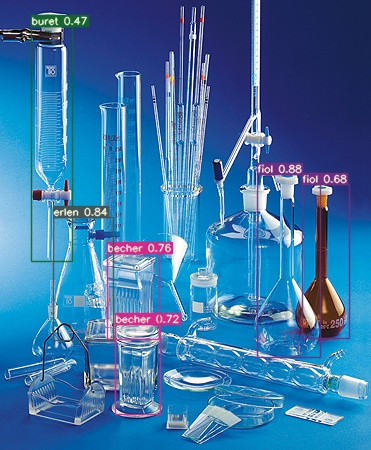

In [ ]:
# Display output
from IPython.display import Image, display
display(Image(filename="/content/drive/Shareddrives/AI/yolov7_train/yolov7/runs/detect/exp4/dung-cu.jpg"))

## Import Library and Define Opt

In [15]:
# Import thư viện để nhận diện ảnh trong thực tế

import os
import sys
sys.path.append('/content/gdrive/MyDrive/yolov7')

import argparse
import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [ ]:
classes_to_filter = None

opt  = {
    
    "weights": "/content/drive/Shareddrives/AI/yolov7_train/yolov7/runs/train/exp3/weights/last.pt", # Path to weights file default weights are for nano model
    "yaml"   : "/content/drive/Shareddrives/AI/yolov7_train/yolov7/data/mydataset.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.8, # confidence threshold for inference.
    "iou-thres" : 0.45, # NMS IoU threshold for inference.
    "device" : 'cpu', # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes" : classes_to_filter  # list of classes to filter or None

}

## Detect directly from image file

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


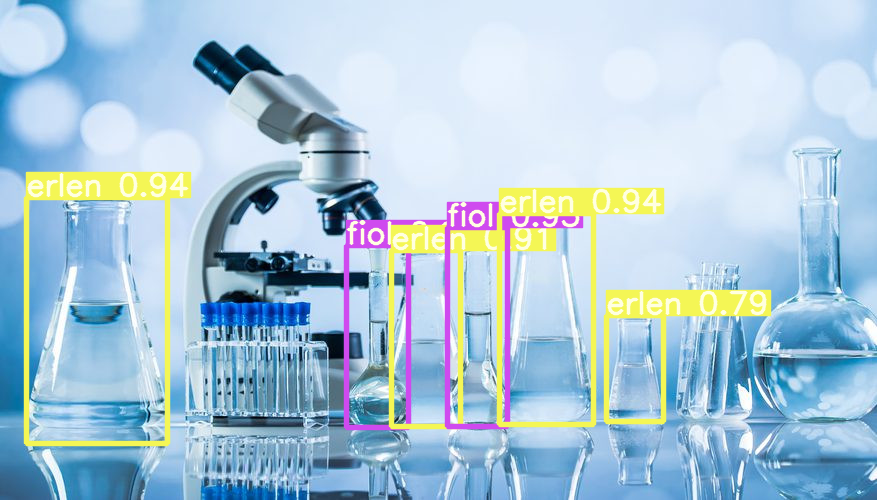

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


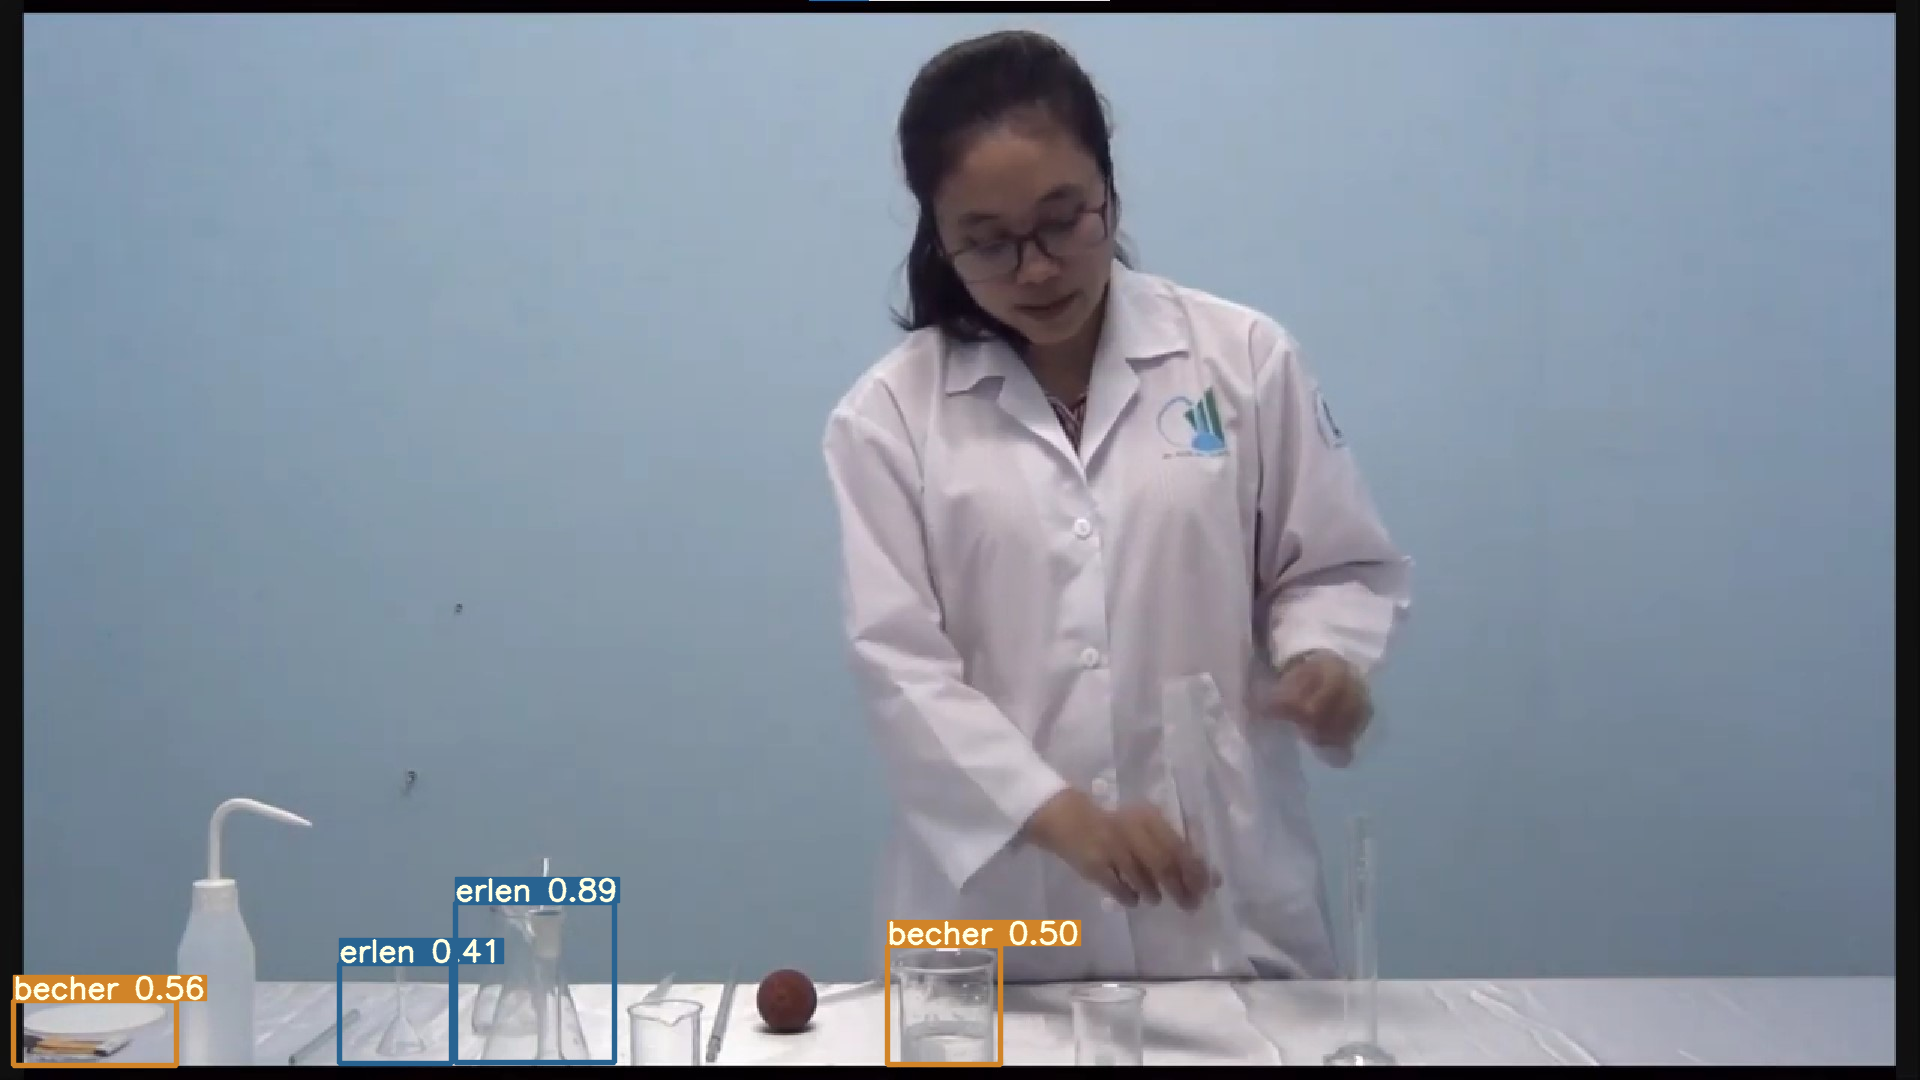

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


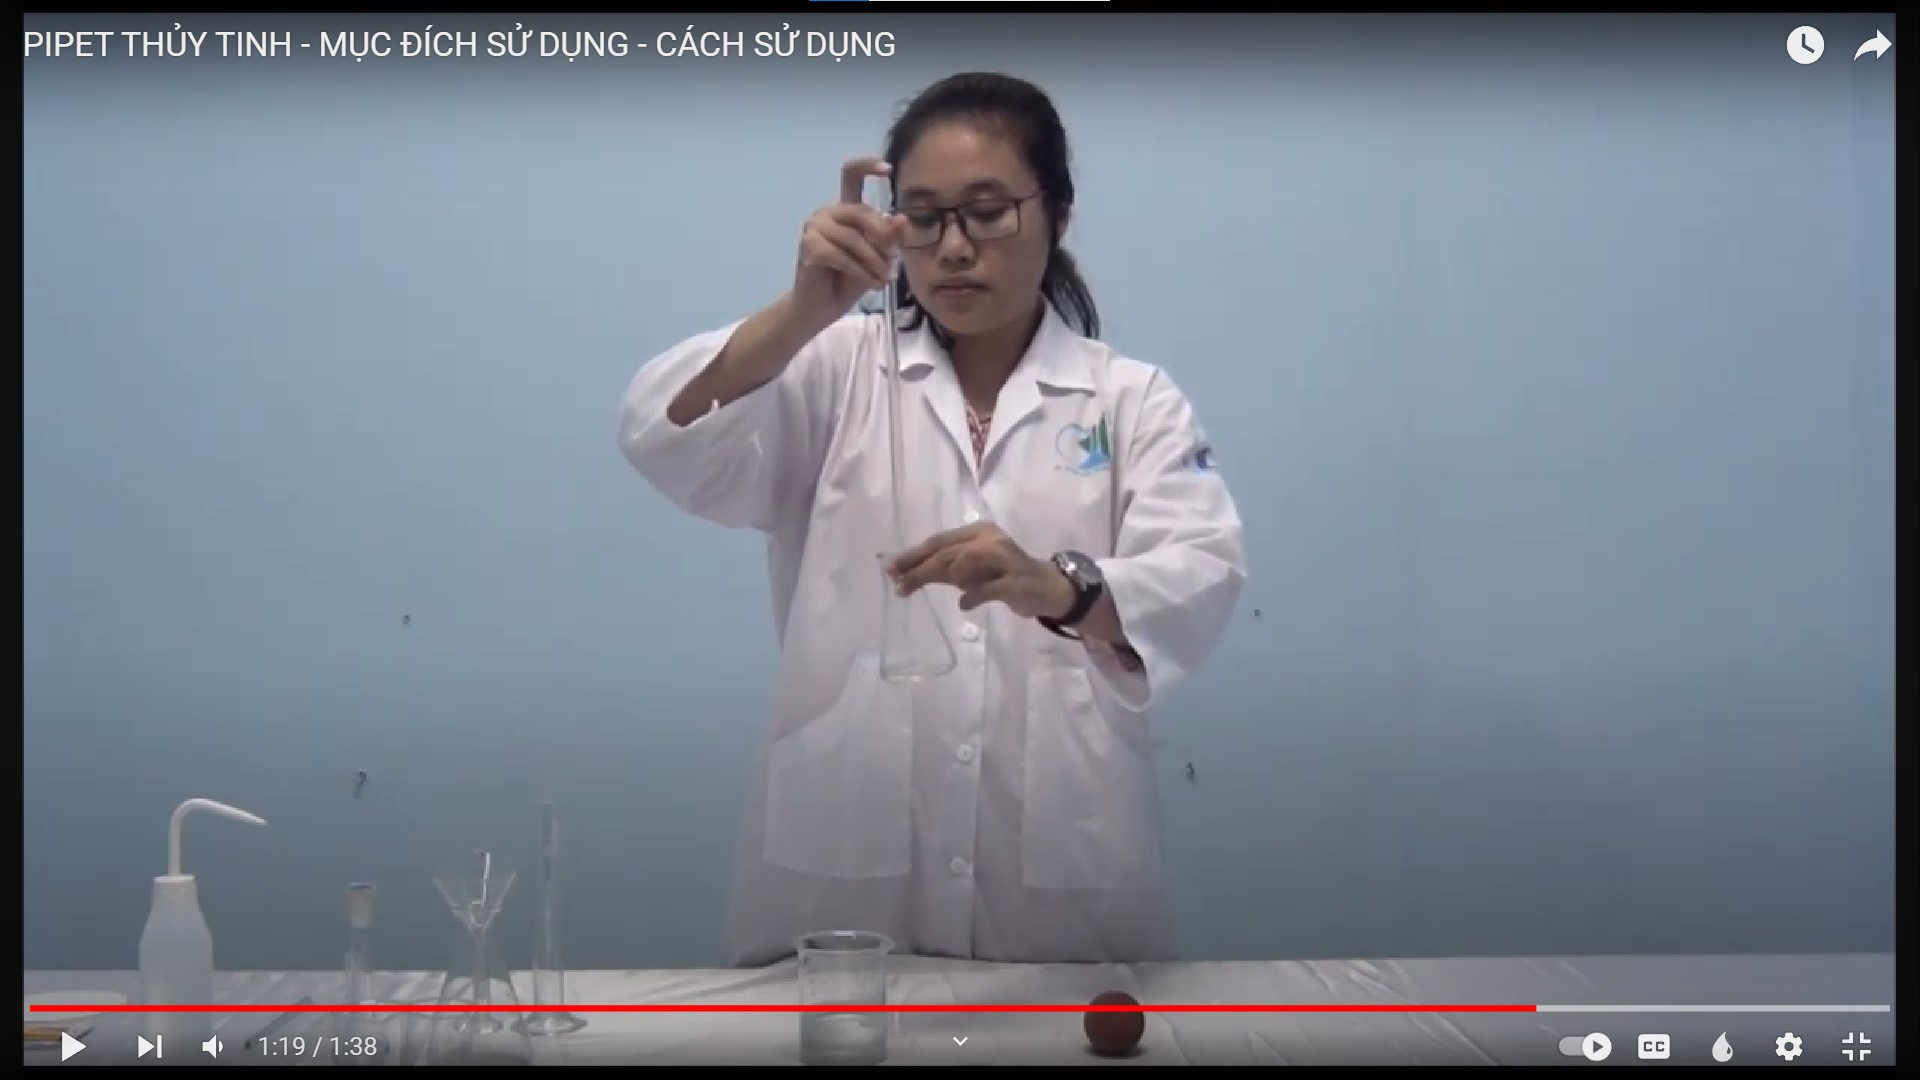

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


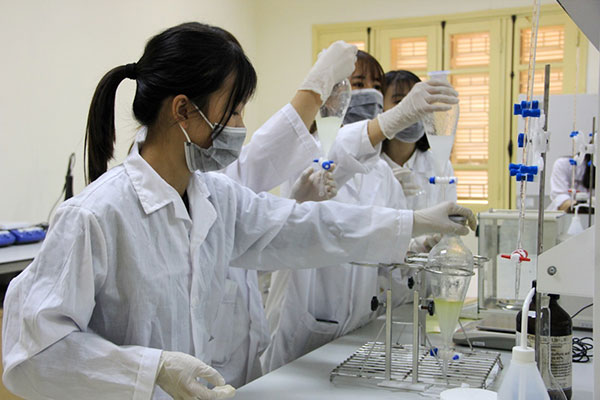

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


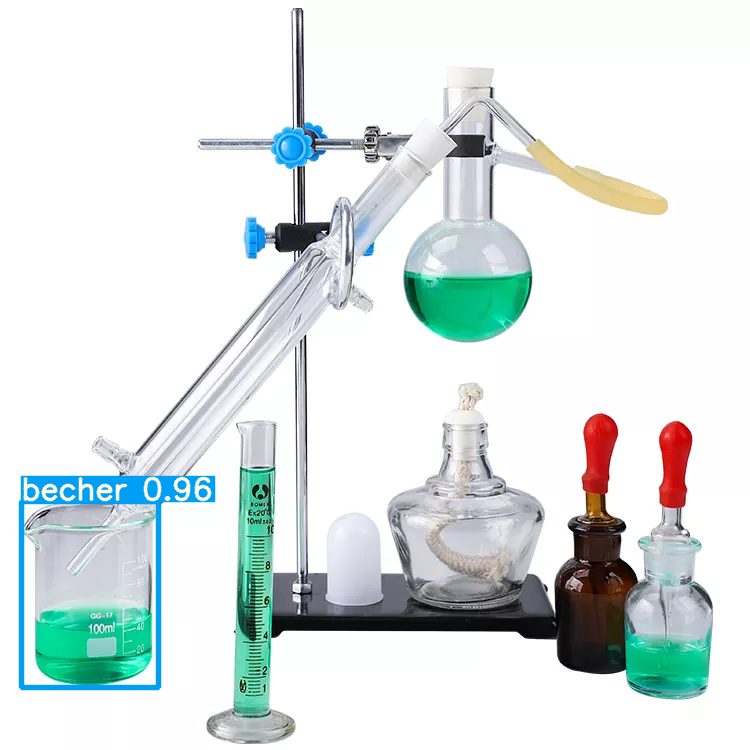

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


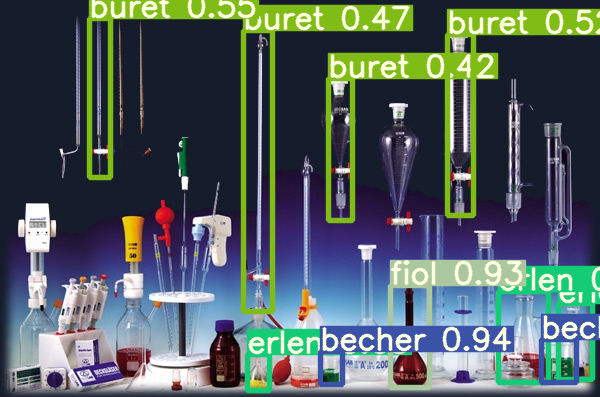

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


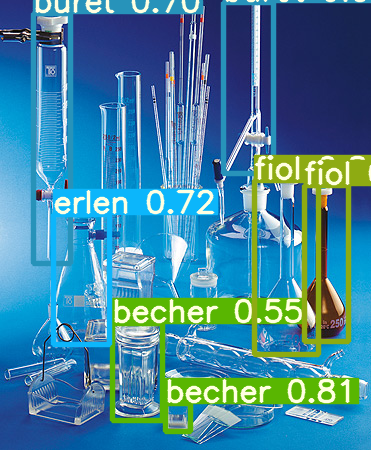

In [28]:
from google.colab.patches import cv2_imshow
def detectImg(source_image_path):
  with torch.no_grad():
    weights, imgsz = opt['weights'], opt['img-size']
    set_logging()
    device = select_device(opt['device'])
    half = device.type != 'cpu'
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    if half:
      model.half()

    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
    if device.type != 'cpu':
      model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

    img0 = cv2.imread(source_image_path)
    img = letterbox(img0, imgsz, stride=stride)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
      img = img.unsqueeze(0)

    # Inference
    t1 = time_synchronized()
    pred = model(img, augment= False)[0]

    # Apply NMS
    classes = None
    if opt['classes']:
      classes = []
      for class_name in opt['classes']:

        classes.append(opt['classes'].index(class_name))


    pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
    t2 = time_synchronized()
    for i, det in enumerate(pred):
      s = ''
      s += '%gx%g ' % img.shape[2:]  # print string
      gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
      if len(det):
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

        for c in det[:, -1].unique():
          n = (det[:, -1] == c).sum()  # detections per class
          s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
      
        for *xyxy, conf, cls in reversed(det):

          label = f'{names[int(cls)]} {conf:.2f}'
          plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=3)
  cv2_imshow(img0)
filename = os.listdir("/content/drive/Shareddrives/AI/Old_Data/SomeTestImages/test")
for i in filename:
  if i.endswith('.jpg'):
    detectImg(f"/content/drive/Shareddrives/AI/Old_Data/SomeTestImages/test/{i}")

## Setup Colab Camera

In [20]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import PIL
import io
import html
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"},
          deviceId: 0
          });
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Detect on Camera

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

with torch.no_grad():
  weights, imgsz = opt['weights'], (480,640)
  set_logging()
  device = select_device(opt['device'])
  half = device.type != 'cpu'
  model = attempt_load(weights, map_location=device)  # load FP32 model
  stride = int(model.stride.max())  # model stride

  if half:
    model.half()

  names = model.module.names if hasattr(model, 'module') else model.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
  if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz[0], imgsz[1]).to(device).type_as(next(model.parameters())))
  classes = None
  if opt['classes']:
    classes = []
    for class_name in opt['classes']:
      classes.append(opt['classes'].index(class_name))
  
  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    
    img0 = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    img = letterbox(img0, imgsz, stride=stride)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
      img = img.unsqueeze(0)

    # Inference
    t1 = time_synchronized()
    pred = model(img, augment= False)[0]

    # Apply NMS
    pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
    t2 = time_synchronized()
    for i, det in enumerate(pred):
      s = ''
      s += '%gx%g ' % img.shape[2:]  # print string
      gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
      if len(det):
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

        for c in det[:, -1].unique():
          n = (det[:, -1] == c).sum()  # detections per class
          s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
    
        for *xyxy, conf, cls in reversed(det):

          label = f'{names[int(cls)]} {conf:.2f}'
          plot_one_box(xyxy, bbox_array, label=label, color=colors[int(cls)], line_thickness=3)
          # print(label)
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    
    bbox = bbox_bytes

## Detect on Video

### Download Video

In [ ]:
# importing the module
!pip install pytube
import pytube
import os
link = "https://www.youtube.com/watch?v=E0cqL3wezV8"
yt = pytube.YouTube(link)
stream = yt.streams.get_highest_resolution()
video_filename = stream.download('/content/test_video')
dst = os.path.splitext(video_filename)[0]+'.mp4'
os.rename(video_filename, dst)
video_filename = dst

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.3 MB/s 


### Detect

In [33]:
# Test Detecton
%cd /content/drive/Shareddrives/AI/yolov7_train/yolov7
!python detect.py --conf 0.5 --weights /content/drive/Shareddrives/AI/yolov7_train/yolov7/runs/train/exp3/weights/last.pt --source "/content/TestVideo.mp4"

/content/drive/Shareddrives/AI/yolov7_train/yolov7
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/content/TestVideo.mp4', update=False, view_img=False, weights=['/content/drive/Shareddrives/AI/yolov7_train/yolov7/runs/train/exp3/weights/last.pt'])
YOLOR 🚀 v0.1-104-g941b94c torch 1.13.0+cu116 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36497954 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert m

### Download weight

In [ ]:
!zip -r /content/exp3.zip /content/drive/Shareddrives/AI/yolov7_train/yolov7/runs/train/exp3 
from google.colab import files
files.download("/content/exp3.zip")